In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pandas as pd
import random as rn
import numpy as np
import json
import cv2
import os
import tensorflow as tf

In [2]:
os.listdir('C:/Users/Otinwa Ayomide/Downloads/new/cassava-leaf-disease-classification')


['label_num_to_disease_map.json',
 'Rdm_src_HPT',
 'sample_submission.csv',
 'test_images',
 'test_tfrecords',
 'train.csv',
 'train_images',
 'train_tfrecords']

In [3]:
# Reading json files to know different classes of possible leaf disease

with open('C:/Users/Otinwa Ayomide/Downloads/new/cassava-leaf-disease-classification/label_num_to_disease_map.json') as f:
    print(json.loads(f.read()))



{'0': 'Cassava Bacterial Blight (CBB)', '1': 'Cassava Brown Streak Disease (CBSD)', '2': 'Cassava Green Mottle (CGM)', '3': 'Cassava Mosaic Disease (CMD)', '4': 'Healthy'}


In [4]:
img_lbl = pd.read_csv('C:/Users/Otinwa Ayomide/Downloads/new/cassava-leaf-disease-classification/train.csv')
img_lbl.head()


image_id  label
0  1000015157.jpg      0
1  1000201771.jpg      3
2   100042118.jpg      1
3  1000723321.jpg      1
4  1000812911.jpg      3

In [5]:
# Removing Duplicate images as mentioned in the discussion ('1562043567.jpg', '3551135685.jpg', '2252529694.jpg' are duplicate)

img_lbl=img_lbl[~img_lbl['image_id'].isin(['1562043567.jpg', '3551135685.jpg', '2252529694.jpg'])]

In [6]:
img_lbl['label'].value_counts()

# Cassava Mosaic Disease (CMD) is the most spread leaf disease.
# Cassava Bacterial Blight (CBB) is the least spread leaf disease.

3    13158
4     2575
2     2386
1     2189
0     1086
Name: label, dtype: int64

In [7]:
# importing some random images

X=[]   # variable to store leaf images
Z=[]   # variable to store leaf diseases

for img, dseas in tqdm(img_lbl.sample(9).values):
    image=cv2.imread('C:/Users/Otinwa Ayomide/Downloads/new/cassava-leaf-disease-classification/train_images/{}'.format(img),
                     cv2.IMREAD_COLOR)
    image=cv2.resize(image,(600,600))
    X.append(image)    # Appending the images into X
    Z.append(dseas)    # Appending the image labels into Z



100%|██████████| 9/9 [00:00<00:00, 65.59it/s]


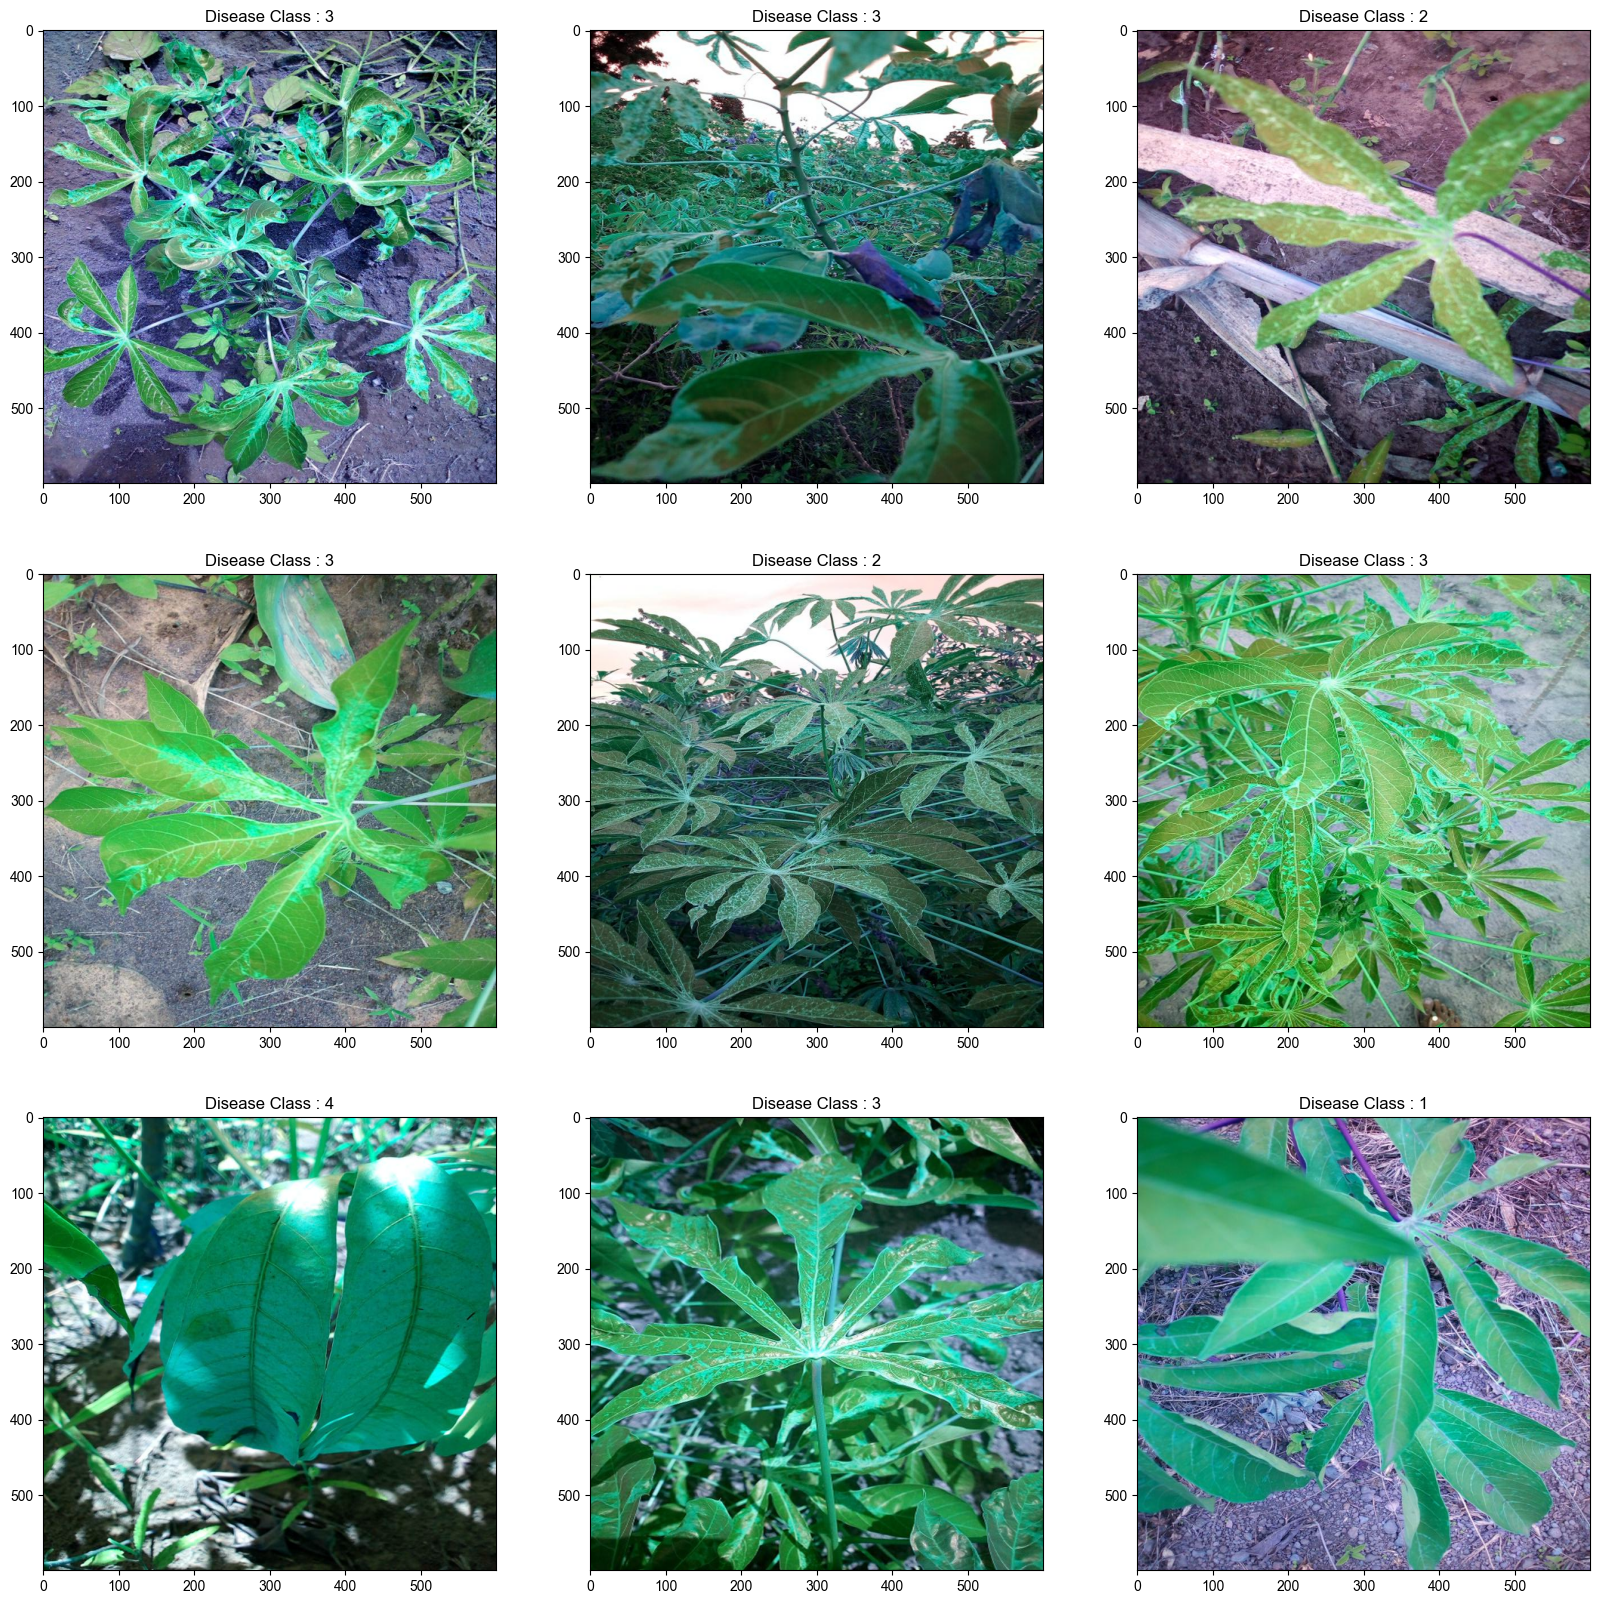

In [8]:
fig, ax=plt.subplots(3,3)
fig.set_size_inches(20,20)
l=0
for row in range(3):    
    for col in range(3):
        ax[row,col].imshow(X[l])
        ax[row,col].set_title('Disease Class : '+str(Z[l]))
        l=l+1

plt.tight_layout
sns.set(font_scale=1.5)

In [9]:
# Splitting data into train andkerasdation

from sklearn.model_selection import train_test_split
train,validation = train_test_split(img_lbl,test_size=0.2,shuffle=True,stratify=img_lbl['label'])

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,GlobalAveragePooling2D,Dense,Flatten,Dropout
from tensorflow.keras.applications import EfficientNetB3

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Imagedatagenerator for training
datagen_trng = ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
                                  rotation_range=30,
                                  width_shift_range=0.3,
                                  height_shift_range=0.3,
                                  shear_range=0.2,
                                  zoom_range=0.3,
                                  horizontal_flip=True,
                                  fill_mode='nearest')

# label should be converted to string to be used
train['label']=train['label'].astype('str')                        

# Augmenting Images for training
train_datagen=datagen_trng.flow_from_dataframe(dataframe=train,
                                        directory='C:/Users/Otinwa Ayomide/Downloads/new/cassava-leaf-disease-classification/train_images',
                                        x_col="image_id",
                                        y_col="label",
                                        color_mode="rgb",
                                        target_size=(300,300),
                                        batch_size=4,
                                        seed=42,
                                        class_mode="categorical")


Found 17115 validated image filenames belonging to 5 classes.


In [12]:
# Imagedatagenerator for validation
datagen_valid = ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet.preprocess_input)

# label should be converted to string to be used
validation['label']=validation['label'].astype('str')

# Augmenting Images for validating
valid_datagen=datagen_valid.flow_from_dataframe(dataframe=validation,
                                        directory='C:/Users/Otinwa Ayomide/Downloads/new/cassava-leaf-disease-classification/train_images',
                                        x_col='image_id',
                                        y_col="label",
                                        color_mode="rgb",
                                        target_size=(300,300),
                                        batch_size=4,
                                        seed=42,
                                        class_mode="categorical")

Found 4279 validated image filenames belonging to 5 classes.


In [13]:
# Defining model

model=Sequential()
model.add(EfficientNetB3(include_top=False,weights='imagenet',input_shape=(300,300,3)))
model.add(GlobalAveragePooling2D())
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(5,activation='softmax'))

model.compile(optimizer=tf.keras.optimizers.Adam(),loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=tf.keras.metrics.CategoricalAccuracy())
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 10, 10, 1536)     10783535  
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 1536)              0         
                                                                 
 dense (Dense)               (None, 128)               196736    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                        

In [14]:
# Defining callbacks

from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

early_stop=EarlyStopping(monitor='val_categorical_accuracy',
                         min_delta=0.002,
                         patience=1,
                         mode='max',
                         verbose=1,
                         restore_best_weights=True)

reduce_lr=ReduceLROnPlateau(monitor='val_categorical_accuracy',
                            patience=2,
                            factor=0.1,
                            mode='max',
                            min_lr=1e-6,
                            verbose=1)

In [15]:
history= model.fit(train_datagen,
                   batch_size=train_datagen.n//train_datagen.batch_size,
                   epochs=5,verbose=1,shuffle=True,
                   validation_data=valid_datagen,
                   callbacks=[early_stop,reduce_lr])

Epoch 1/5
4279/4279 [==============================] - 6976s 2s/step - loss: 1.0798 - categorical_accuracy: 0.6153 - val_loss: 0.8984 - val_categorical_accuracy: 0.6151 - lr: 0.0010
Epoch 2/5
4279/4279 [==============================] - 7166s 2s/step - loss: 0.9837 - categorical_accuracy: 0.6431 - val_loss: 0.7658 - val_categorical_accuracy: 0.6939 - lr: 0.0010
Epoch 3/5
4279/4279 [==============================] - 70190s 16s/step - loss: 0.8923 - categorical_accuracy: 0.6714 - val_loss: 0.7945 - val_categorical_accuracy: 0.6918 - lr: 0.0010
Epoch 3: early stopping


In [16]:
model_eval=model.evaluate(valid_datagen,verbose=1)
print('Validation loss: ',model_eval[0])
print('Validation accuracy: ',model_eval[1])

1070/1070 [==============================] - 337s 315ms/step - loss: 0.7658 - categorical_accuracy: 0.6939
Validation loss:  0.7657790780067444
Validation accuracy:  0.6938536763191223


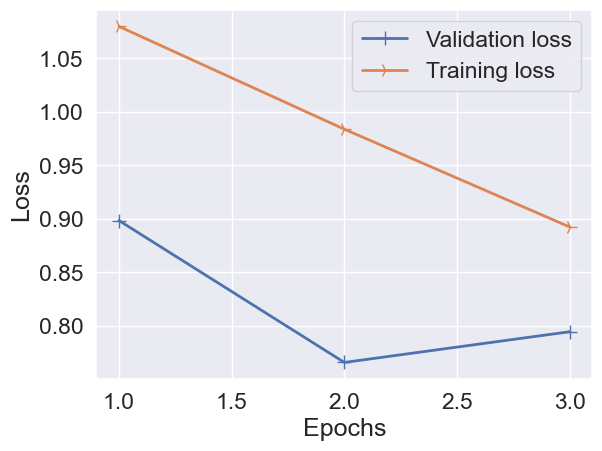

In [17]:
history_dict=history.history

loss_value=history_dict['loss']
val_loss_value=history_dict['val_loss']
epoch=range(1,len(loss_value)+1)

lin1=plt.plot(epoch,val_loss_value,label='Validation loss')
lin2=plt.plot(epoch,loss_value,label='Training loss')
plt.setp(lin1,linewidth=2.0,marker='+',markersize=10.0)
plt.setp(lin2,linewidth=2.0,marker='4',markersize=10.0)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

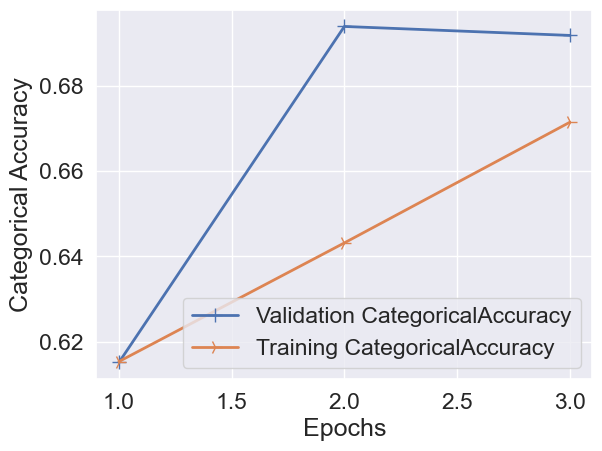

In [18]:
acc_value=history_dict['categorical_accuracy']
val_acc_value=history_dict['val_categorical_accuracy']
epoch=range(1,len(loss_value)+1)

lin1=plt.plot(epoch,val_acc_value,label='Validation CategoricalAccuracy')
lin2=plt.plot(epoch,acc_value,label='Training CategoricalAccuracy')
plt.setp(lin1,linewidth=2.0,marker='+',markersize=10.0)
plt.setp(lin2,linewidth=2.0,marker='4',markersize=10.0)
plt.xlabel('Epochs')
plt.ylabel('Categorical Accuracy')
plt.grid(True)
plt.legend()

In [19]:
def model_optimse(hp):
    model_hpt=Sequential()
    model_hpt.add(EfficientNetB3(include_top=False,weights='imagenet',input_shape=(420,420,3)))
    model_hpt.add(GlobalAveragePooling2D())
    for i in range(hp.Int('layers',1,5)):
        model_hpt.add(Dense(units=hp.Int('Neurons_in_layer_'+str(i),min_value=32,max_value=512,step=32),
                            activation=hp.Choice('activation_funct',['relu','sigmoid'])))
    model_hpt.add(Dense(5,activation='softmax'))
    
    model_hpt.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=hp.Choice('lrn_rate',values=[1e-4,3e-5,7e-5,1e-5])),
                      loss=tf.keras.losses.CategoricalCrossentropy(),metrics=tf.keras.metrics.CategoricalAccuracy())
    
    return model_hpt

In [20]:
from kerastuner.tuners import RandomSearch

hpt_tuner=RandomSearch(model_optimse,
                       max_trials=20,
                       objective='val_loss',
                       project_name='Rdm_src_HPT',
                       directory='C:/Users/Otinwa Ayomide/Downloads/new/cassava-leaf-disease-classification')

INFO:tensorflow:Reloading Oracle from existing project C:/Users/Otinwa Ayomide/Downloads/new/cassava-leaf-disease-classification\Rdm_src_HPT\oracle.json


C:\Users\Otinwa Ayomide\AppData\Local\Temp\ipykernel_18720\489563454.py:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


INFO:tensorflow:Reloading Tuner from C:/Users/Otinwa Ayomide/Downloads/new/cassava-leaf-disease-classification\Rdm_src_HPT\tuner0.json


In [21]:
hpt_tuner.search(train_datagen,
                 batch_size=train_datagen.n//train_datagen.batch_size,
                 epochs=2,
                 validation_data=valid_datagen)

INFO:tensorflow:Oracle triggered exit


In [22]:
model.save('cassava_leaf.h5')